## Part 1: Data preprocessing
In this part, we are going to perform a `step by step actions to convert our text to embeddings`. Firstly, we feed our dataset into the `tokenizer` function from common_utils.py. This step will conver a sequence of text into separable token. For example: text = 'I love this flavor!' will become ['I', 'love', 'this', 'flavor', '!']. After having the words splitted up, we can apply the current state-of-the-art context aware `word embeddings` - BERT, to convert our one-hot vector to context-aware embeddings. For example, the first splitted word 'I' will initially have a one hot vector with the size of the vector equals to the size of the vocabulary. 'I' == [0,0,0,0,...,0,1,0.....,0,0] == Token IDs (integers). Applying BERT on it will make the token ID into context aware embeddings. 'I' == [0.1,0.34,0.56,....,0.9,0.5]. After this step, we are ready to use it as the `input for our model.`

In [1]:
from common_utils import *

In [2]:
from datasets import load_dataset

wassa_dataset = load_dataset("csv", data_files="./dataset/text_emotion.csv")
wassa_dataset = wassa_dataset.rename_column('content', 'text')

wassa_vocab = tokenize(wassa_dataset['train'], save=True)

Vocabulary size: 59121
Vocabulary saved to ./result/vocab.json


In [3]:
embedding_matrix, word2idx = create_embedding_matrix(wassa_vocab, save=True)

Repo card metadata block was not found. Setting CardData to empty.


Total GloVe words loaded: 400000
Embedding Matrix saved to ./result/embedding_matrix.npy
Word to Index mapping saved to ./result/word2idx.json


In [4]:
len(embedding_matrix)

59123

In [5]:
wassa_dataset_dict = create_train_validation_test(wassa_dataset['train'])

Train size: 28000
Validation size: 4000
Test size: 8000


### Check the average sequence length for the dataset

In [7]:
import nltk
import numpy as np
from tqdm import tqdm

def get_seq_length_stats(dataset):
    lengths = []
    for example in tqdm(dataset, desc="Calculating sequence lengths"):
        tokens = nltk.word_tokenize(example["text"])
        lengths.append(len(tokens))
    
    lengths = np.array(lengths)
    return {
        "min_length": int(np.min(lengths)),
        "max_length": int(np.max(lengths)),
        "mean_length": float(np.mean(lengths)),
        "median_length": int(np.median(lengths)),
        "95th_percentile": int(np.percentile(lengths, 95)),
        "99th_percentile": int(np.percentile(lengths, 99))
    }

train_stats = get_seq_length_stats(wassa_dataset_dict['train'])
print("\nTrain set sequence length statistics:")
for stat, value in train_stats.items():
    print(f"{stat}: {value}")

val_stats = get_seq_length_stats(wassa_dataset_dict['validation'])
print("\nValidation set sequence length statistics:")
for stat, value in val_stats.items():
    print(f"{stat}: {value}")

test_stats = get_seq_length_stats(wassa_dataset_dict['test'])
print("\nTest set sequence length statistics:")
for stat, value in test_stats.items():
    print(f"{stat}: {value}")

Calculating sequence lengths: 100%|██████████| 28000/28000 [00:08<00:00, 3144.97it/s]



Train set sequence length statistics:
min_length: 1
max_length: 106
mean_length: 16.433821428571427
median_length: 15
95th_percentile: 31
99th_percentile: 36


Calculating sequence lengths: 100%|██████████| 4000/4000 [00:01<00:00, 3475.65it/s]



Validation set sequence length statistics:
min_length: 1
max_length: 91
mean_length: 16.40625
median_length: 15
95th_percentile: 31
99th_percentile: 36


Calculating sequence lengths: 100%|██████████| 8000/8000 [00:01<00:00, 4879.55it/s]


Test set sequence length statistics:
min_length: 1
max_length: 78
mean_length: 16.49775
median_length: 15
95th_percentile: 31
99th_percentile: 36


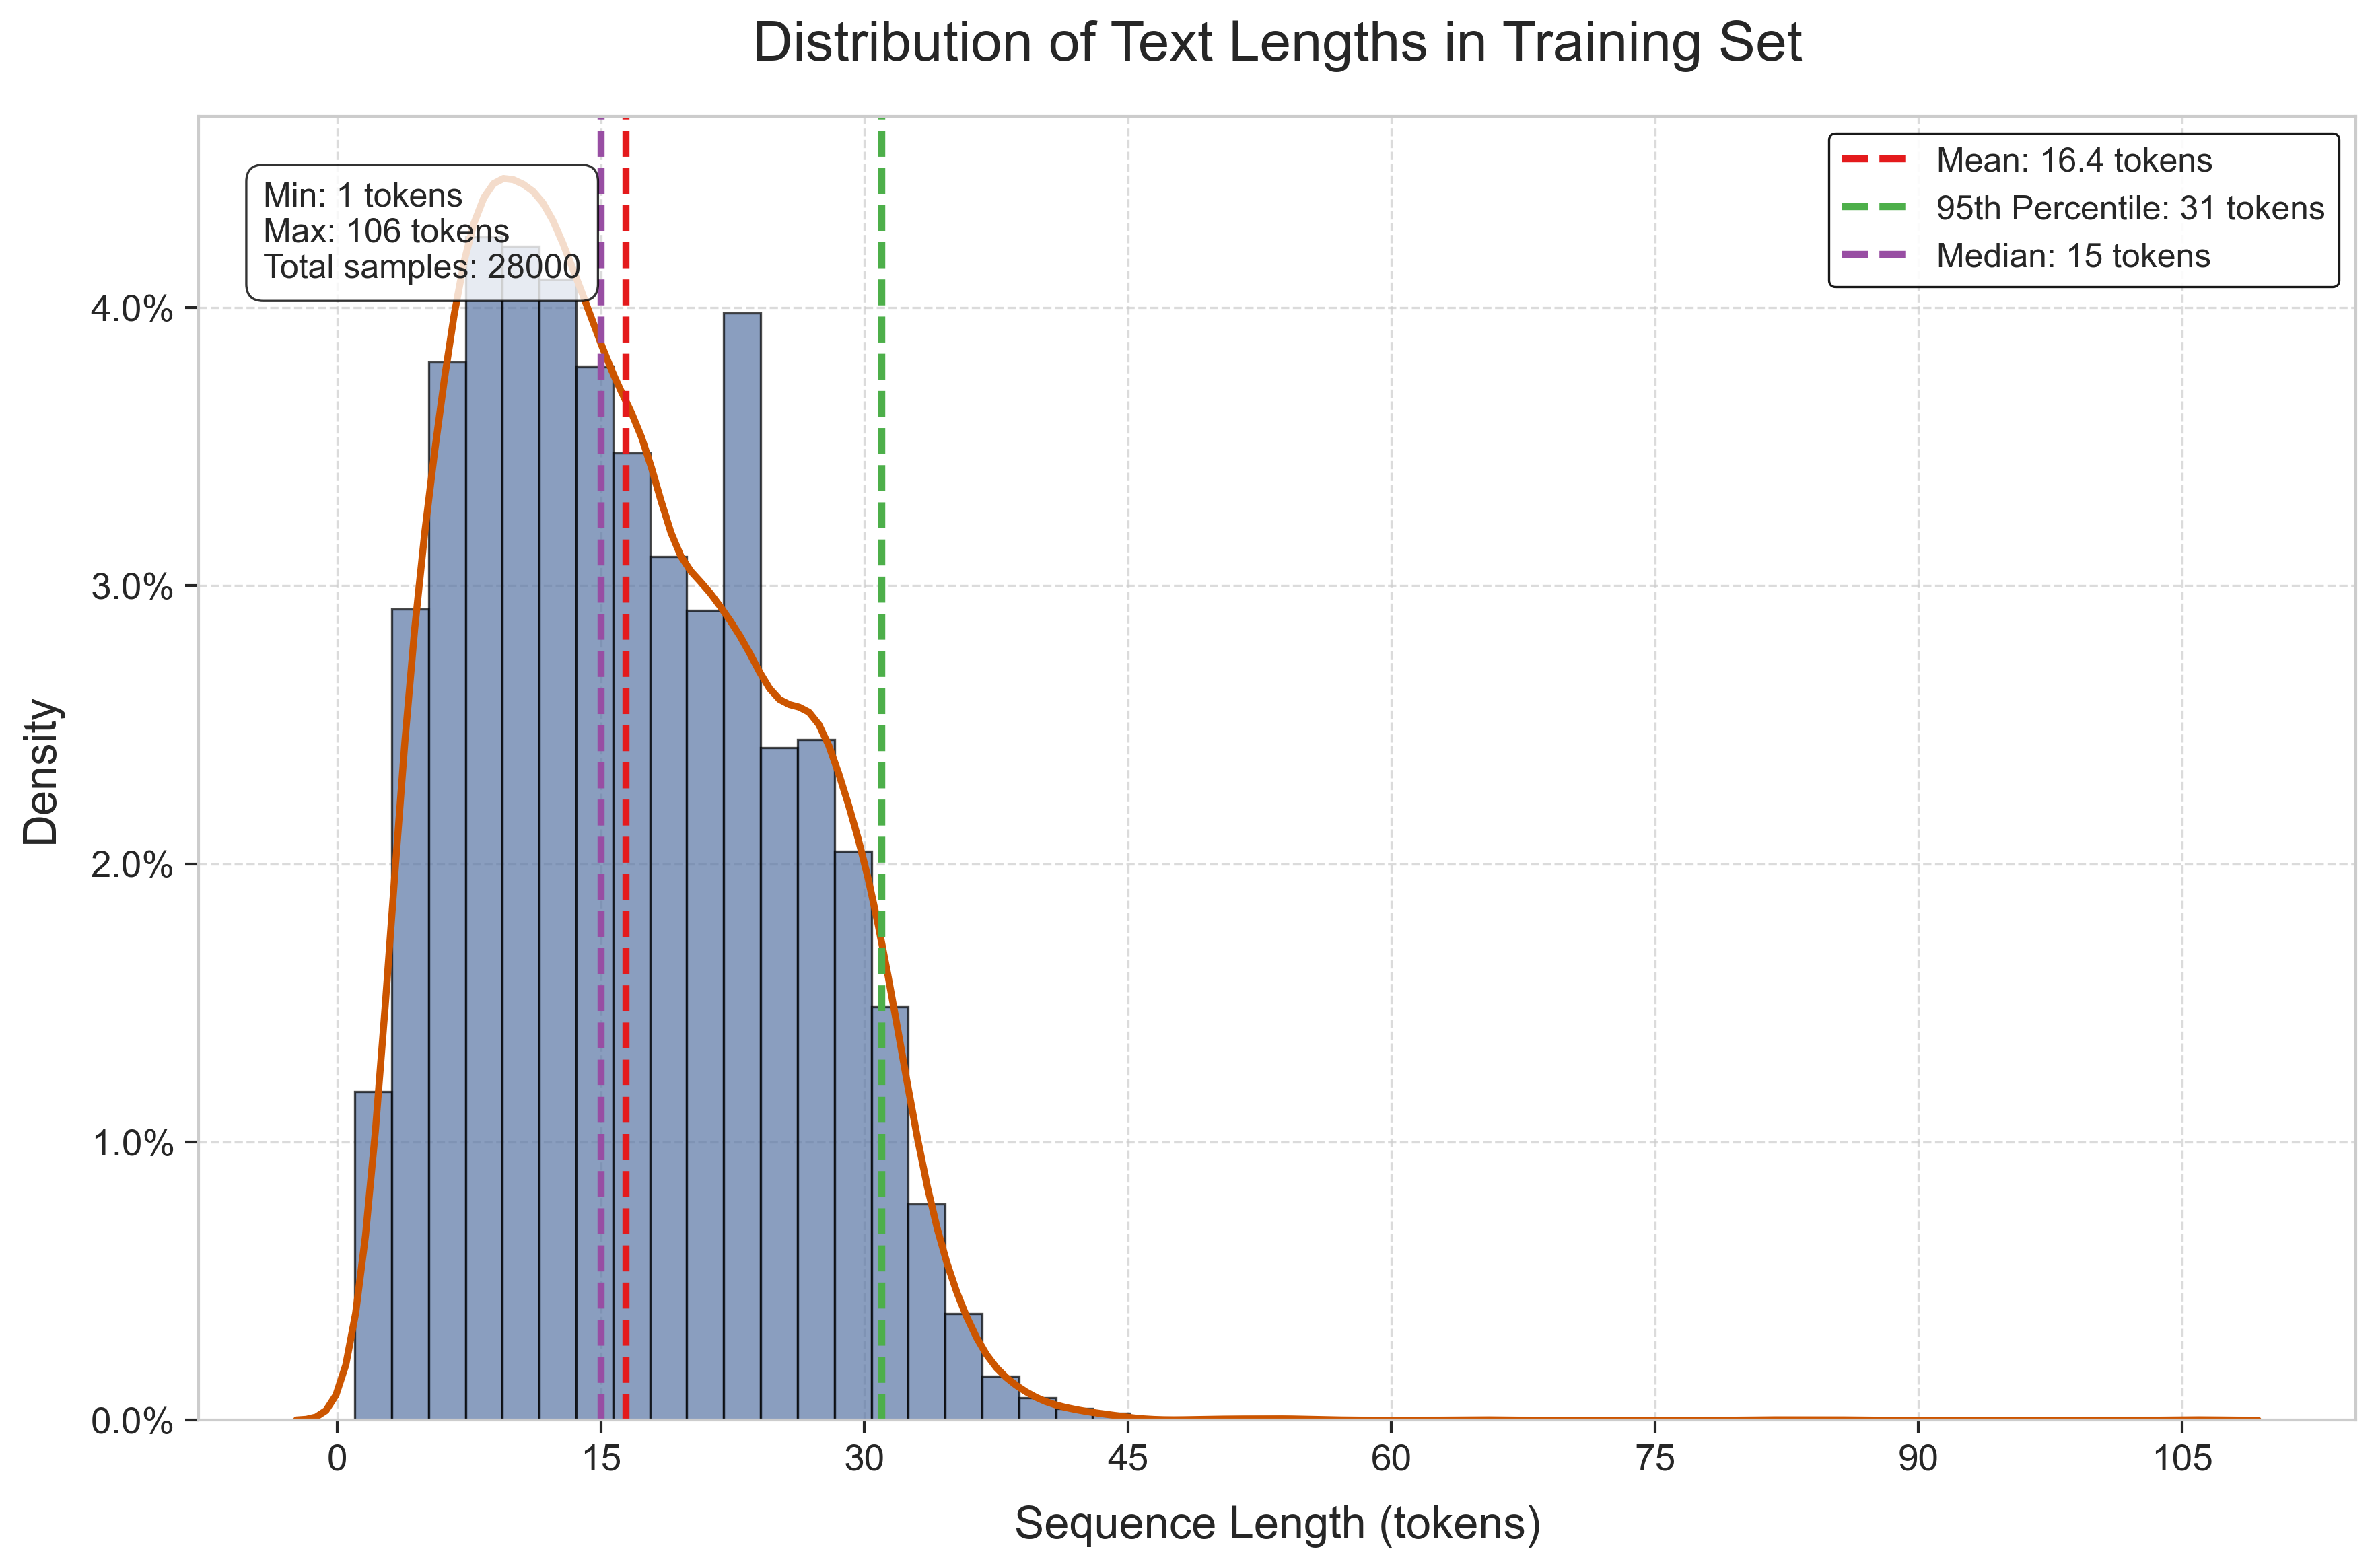

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.5)

seq_lengths = [len(nltk.word_tokenize(example["text"])) for example in wassa_dataset_dict['train']]

fig = plt.figure(figsize=(12, 8), dpi=300)
ax = plt.gca()

n, bins, patches = plt.hist(seq_lengths, bins=50, alpha=0.7, color='#5975A4', edgecolor='black', linewidth=0.8, density=True)
sns.kdeplot(seq_lengths, color='#CC5500', linewidth=2.5)

plt.axvline(train_stats['mean_length'], color='#E41A1C', linestyle='dashed', linewidth=2.5, label=f"Mean: {train_stats['mean_length']:.1f} tokens")
plt.axvline(train_stats['95th_percentile'], color='#4DAF4A', linestyle='dashed', linewidth=2.5, label=f"95th Percentile: {train_stats['95th_percentile']} tokens")
plt.axvline(train_stats['median_length'], color='#984EA3', linestyle='dashed', linewidth=2.5, label=f"Median: {train_stats['median_length']} tokens")

plt.title('Distribution of Text Lengths in Training Set', fontsize=20, pad=20)
plt.xlabel('Sequence Length (tokens)', fontsize=16, labelpad=10)
plt.ylabel('Density', fontsize=16, labelpad=10)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.1%}'.format(x)))

legend = plt.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=12)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.8)

stats_text = (f"Min: {train_stats['min_length']} tokens\n"
              f"Max: {train_stats['max_length']} tokens\n"
              f"Total samples: {len(seq_lengths)}")
plt.annotate(stats_text, xy=(0.03, 0.95), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.8),fontsize=12, va='top')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'sequence_length_distribution.png'), bbox_inches='tight', dpi=300)
plt.show()